Null values in each column:
 Booking_ID                  0
number of adults            0
number of children          0
number of weekend nights    0
number of week nights       0
type of meal                0
car parking space           0
room type                   0
lead time                   0
market segment type         0
repeated                    0
P-C                         0
P-not-C                     0
average price               0
special requests            0
date of reservation         0
booking status              0
dtype: int64

Data types of each column:
 Booking_ID                   object
number of adults              int64
number of children            int64
number of weekend nights      int64
number of week nights         int64
type of meal                 object
car parking space             int64
room type                    object
lead time                     int64
market segment type          object
repeated                      int64
P-C                    

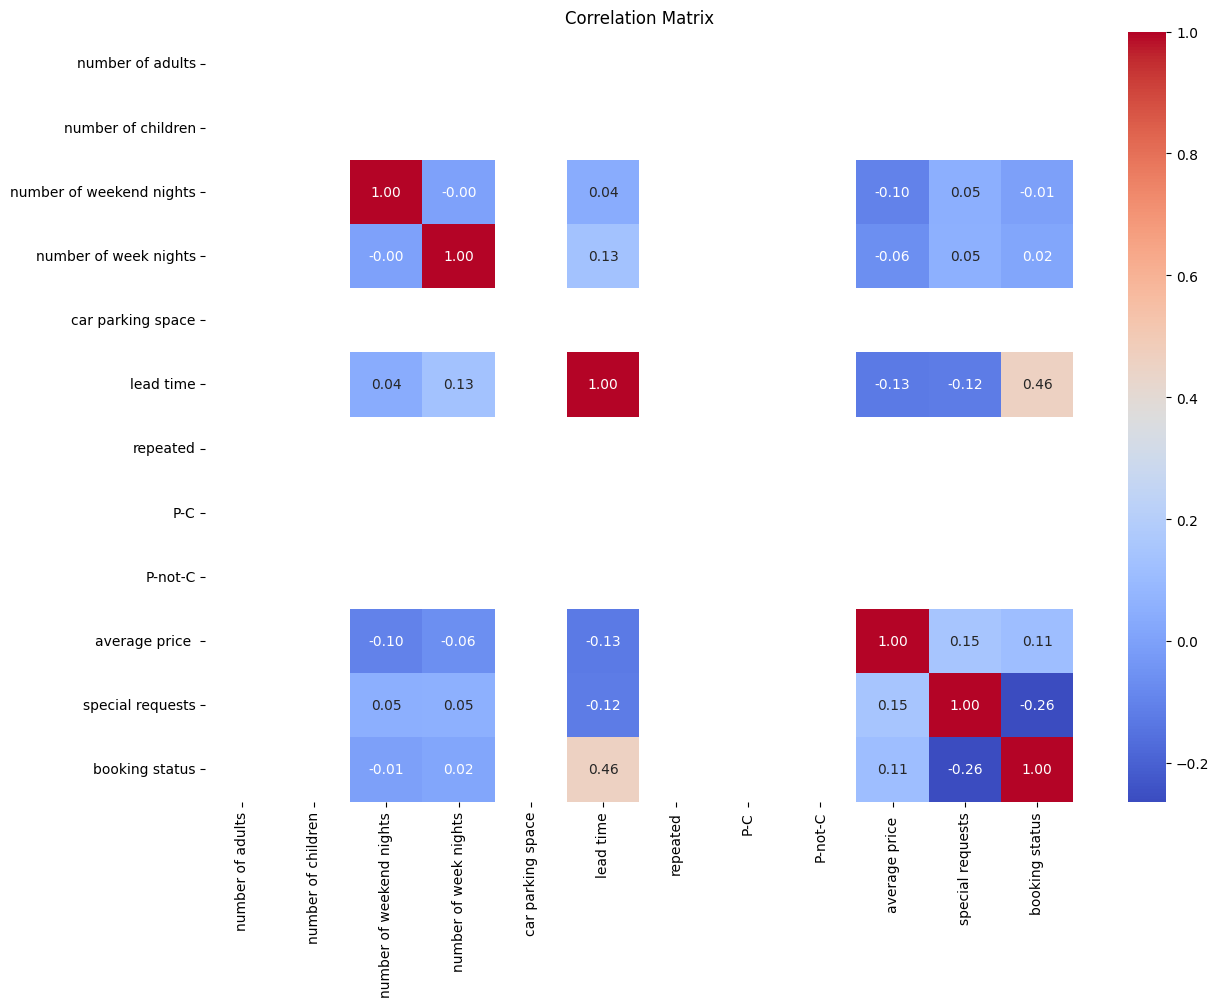

Correlation with booking status:
 booking status              1.000000
lead time                   0.461122
average price               0.113955
number of week nights       0.015173
number of weekend nights   -0.005833
special requests           -0.263059
number of adults                 NaN
number of children               NaN
car parking space                NaN
repeated                         NaN
P-C                              NaN
P-not-C                          NaN
Name: booking status, dtype: float64
Selected features based on correlation:
 ['lead time', 'average price ', 'special requests']

First few rows after feature engineering:
    Booking_ID  number of adults  number of children  number of weekend nights  \
12   INN00013                 2                   0                         2   
14   INN00015                 2                   0                         0   
15   INN00016                 2                   0                         0   
17   INN00018           

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load the data
data = pd.read_csv(r"/content/first inten project.csv")

# 1. Data Preprocessing

# Check for null values
print("Null values in each column:\n", data.isnull().sum())

# Check data types
print("\nData types of each column:\n", data.dtypes)

# Strip whitespace from string columns
for col in data.select_dtypes(include=['object']).columns:
    data[col] = data[col].str.strip()

# Convert 'date of reservation' to datetime format, handle errors by setting invalid parsing as NaT
data['date of reservation'] = pd.to_datetime(data['date of reservation'], errors='coerce')

# Check for any NaT values in the date column
invalid_dates = data[data['date of reservation'].isna()]
print(f"Invalid dates found: {len(invalid_dates)}")
print(invalid_dates)

# Drop rows with NaT in 'date of reservation'
data = data.dropna(subset=['date of reservation'])

# Display the first few rows to ensure the changes
print("\nFirst few rows after cleaning:\n", data.head())

# 2. Check and Handle Outliers Using IQR

# Identify numeric columns
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
print("Numeric columns:\n", numeric_cols)

# Function to remove outliers using IQR method
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Remove outliers using IQR method
data_iqr = remove_outliers_iqr(data.copy(), numeric_cols)
print("Data shape after IQR outlier removal:", data_iqr.shape)

# 3. Feature Engineering

# Encode 'booking status' to numerical values
data_iqr['booking status'] = data_iqr['booking status'].apply(lambda x: 1 if x == 'Canceled' else 0)

# Drop non-numeric columns before calculating the correlation matrix
numeric_data = data_iqr.select_dtypes(include=['int64', 'float64'])

# Calculate the correlation matrix
correlation_matrix = numeric_data.corr()

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Get the correlation of each feature with the target variable
target_corr = correlation_matrix['booking status'].sort_values(ascending=False)
print("Correlation with booking status:\n", target_corr)

# Selecting features with high correlation with the target variable
selected_features = target_corr[abs(target_corr) > 0.1].index.tolist()
selected_features.remove('booking status')  # Remove the target variable itself
print("Selected features based on correlation:\n", selected_features)

# Extract year, month, and day from 'date of reservation'
data_iqr['reservation_year'] = data_iqr['date of reservation'].dt.year
data_iqr['reservation_month'] = data_iqr['date of reservation'].dt.month
data_iqr['reservation_day'] = data_iqr['date of reservation'].dt.day

# Drop the original 'date of reservation' column
data_iqr.drop(columns=['date of reservation'], inplace=True)

# Create a new feature: total number of people
data_iqr['total_people'] = data_iqr['number of adults'] + data_iqr['number of children']

# Display the first few rows to ensure the changes
print("\nFirst few rows after feature engineering:\n", data_iqr.head())

# 4. Transformation for Categorical Data

# Identify categorical columns and exclude 'Booking_ID'
categorical_cols = data_iqr.select_dtypes(include=['object']).columns
categorical_cols = categorical_cols.drop('Booking_ID', errors='ignore')
print("Categorical columns:\n", categorical_cols)

# OneHotEncode categorical features
onehotencoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_categorical = onehotencoder.fit_transform(data_iqr[categorical_cols])
encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=onehotencoder.get_feature_names_out(categorical_cols))

# Merge the encoded categorical features back into the dataframe
data_iqr = pd.concat([data_iqr.reset_index(drop=True), encoded_categorical_df.reset_index(drop=True)], axis=1)
data_iqr.drop(columns=categorical_cols, inplace=True)

# 5. Train Test Split

# Define features and target variable
X = data_iqr.drop(columns=['booking status', 'Booking_ID'], errors='ignore')
y = data_iqr['booking status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. Modeling and Accuracy Calculation

# Define the models to train
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC()
}

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {model_name}: {accuracy:.2f}")
    print(f"Confusion Matrix for {model_name}:\n{confusion_matrix(y_test, y_pred)}")
    print(f"Classification Report for {model_name}:\n{classification_report(y_test, y_pred)}\n")

# Display the model with the highest accuracy
best_model = max(models.items(), key=lambda x: accuracy_score(y_test, x[1].predict(X_test_scaled)))
print(f"The best model is {best_model[0]} with an accuracy of {accuracy_score(y_test, best_model[1].predict(X_test_scaled)):.2f}")


In [3]:
from sklearn.model_selection import GridSearchCV
import joblib

# Define the parameter grids for each model
param_grid_lr = {
    'C': [0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear']
}

param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf']
}

# Initialize the models
lr = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier()
svc = SVC()

# Initialize GridSearchCV for each model
grid_search_lr = GridSearchCV(estimator=lr, param_grid=param_grid_lr, cv=3, n_jobs=-1, scoring='accuracy')
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=3, n_jobs=-1, scoring='accuracy')
grid_search_svc = GridSearchCV(estimator=svc, param_grid=param_grid_svc, cv=3, n_jobs=-1, scoring='accuracy')

# Use joblib to parallelize the fitting process and optimize memory usage
with joblib.parallel_backend('loky'):
    grid_search_lr.fit(X_train_scaled, y_train)
    grid_search_rf.fit(X_train_scaled, y_train)
    grid_search_svc.fit(X_train_scaled, y_train)

# Get the best parameters and the best score for each model
best_params_lr = grid_search_lr.best_params_
best_score_lr = grid_search_lr.best_score_

best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

best_params_svc = grid_search_svc.best_params_
best_score_svc = grid_search_svc.best_score_

print(f"Best parameters for Logistic Regression: {best_params_lr}")
print(f"Best cross-validation accuracy for Logistic Regression: {best_score_lr:.2f}\n")

print(f"Best parameters for Random Forest: {best_params_rf}")
print(f"Best cross-validation accuracy for Random Forest: {best_score_rf:.2f}\n")

print(f"Best parameters for Support Vector Machine: {best_params_svc}")
print(f"Best cross-validation accuracy for Support Vector Machine: {best_score_svc:.2f}\n")

# Evaluate the best models on the test set
best_lr = grid_search_lr.best_estimator_
best_rf = grid_search_rf.best_estimator_
best_svc = grid_search_svc.best_estimator_

# Predict and evaluate the best Logistic Regression model
y_pred_lr = best_lr.predict(X_test_scaled)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Test accuracy for Logistic Regression: {accuracy_lr:.2f}")
print(f"Confusion Matrix for Logistic Regression:\n{confusion_matrix(y_test, y_pred_lr)}")
print(f"Classification Report for Logistic Regression:\n{classification_report(y_test, y_pred_lr)}\n")

# Predict and evaluate the best Random Forest model
y_pred_rf = best_rf.predict(X_test_scaled)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Test accuracy for Random Forest: {accuracy_rf:.2f}")
print(f"Confusion Matrix for Random Forest:\n{confusion_matrix(y_test, y_pred_rf)}")
print(f"Classification Report for Random Forest:\n{classification_report(y_test, y_pred_rf)}\n")

# Predict and evaluate the best Support Vector Machine model
y_pred_svc = best_svc.predict(X_test_scaled)
accuracy_svc = accuracy_score(y_test, y_pred_svc)
print(f"Test accuracy for Support Vector Machine: {accuracy_svc:.2f}")
print(f"Confusion Matrix for Support Vector Machine:\n{confusion_matrix(y_test, y_pred_svc)}")
print(f"Classification Report for Support Vector Machine:\n{classification_report(y_test, y_pred_svc)}\n")

# Display the model with the highest test accuracy
best_model_name = 'Logistic Regression' if accuracy_lr > accuracy_rf and accuracy_lr > accuracy_svc else 'Random Forest' if accuracy_rf > accuracy_lr and accuracy_rf > accuracy_svc else 'Support Vector Machine'
best_model_accuracy = max(accuracy_lr, accuracy_rf, accuracy_svc)
print(f"The best model is {best_model_name} with a test accuracy of {best_model_accuracy:.2f}")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


Best parameters for Logistic Regression: {'C': 0.1, 'solver': 'liblinear'}
Best cross-validation accuracy for Logistic Regression: 0.80

Best parameters for Random Forest: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy for Random Forest: 0.88

Best parameters for Support Vector Machine: {'C': 10, 'kernel': 'rbf'}
Best cross-validation accuracy for Support Vector Machine: 0.84

Test accuracy for Logistic Regression: 0.80
Confusion Matrix for Logistic Regression:
[[3631  500]
 [ 795 1426]]
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      4131
           1       0.74      0.64      0.69      2221

    accuracy                           0.80      6352
   macro avg       0.78      0.76      0.77      6352
weighted avg       0.79      0.80      0.79      6352


Test accuracy for Random Forest: 0.88
Confusion Matrix for Random Forest:
[[3839  292

In [4]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest for feature selection
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X_train_scaled, y_train)

# Use SelectFromModel to select features
selector = SelectFromModel(rf_selector, prefit=True)
X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)

print(f"Selected features shape: {X_train_selected.shape}")

# Retrain and evaluate models with selected features
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC()
}

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {model_name} with selected features: {accuracy:.2f}")
    print(f"Confusion Matrix for {model_name}:\n{confusion_matrix(y_test, y_pred)}")
    print(f"Classification Report for {model_name}:\n{classification_report(y_test, y_pred)}\n")


Selected features shape: (14820, 6)
Accuracy for Logistic Regression with selected features: 0.77
Confusion Matrix for Logistic Regression:
[[3675  456]
 [ 993 1228]]
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.79      0.89      0.84      4131
           1       0.73      0.55      0.63      2221

    accuracy                           0.77      6352
   macro avg       0.76      0.72      0.73      6352
weighted avg       0.77      0.77      0.76      6352


Accuracy for Random Forest with selected features: 0.86
Confusion Matrix for Random Forest:
[[3813  318]
 [ 541 1680]]
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      4131
           1       0.84      0.76      0.80      2221

    accuracy                           0.86      6352
   macro avg       0.86      0.84      0.85      6352
weighted avg       0.86   

In [6]:
import joblib

# Save the best model using joblib
joblib.dump(best_lr, 'best_logistic_regression_model.pkl')
joblib.dump(best_rf, 'best_random_forest_model.pkl')
joblib.dump(best_svc, 'best_svm_model.pkl')


['best_svm_model.pkl']